In [ ]:
!pip install pandas numpy matplotlib wordcloud nltk spacy

In [ ]:
import pandas as pd

twitter_url = "https://raw.githubusercontent.com/WinNatch/Dissertation/main/airbnb_twitter_full_data.csv"
reddit_url = "https://raw.githubusercontent.com/WinNatch/Dissertation/main/airbnb_reddit_data.csv"
trustpilot_url = "https://raw.githubusercontent.com/WinNatch/Dissertation/main/airbnb_trustpilot_data.csv"

In [ ]:
twitter_df = pd.read_csv(twitter_url)
reddit_df = pd.read_csv(reddit_url)
trustpilot_df = pd.read_csv(trustpilot_url)

print("Twitter columns:", twitter_df.columns.tolist())
print("Reddit columns:", reddit_df.columns.tolist())
print("Trustpilot columns:", trustpilot_df.columns.tolist())

Twitter columns: ['Timestamp', 'Text', 'Source', 'Like_Count', 'Retweet_Count', 'Reply_Count']
Reddit columns: ['Timestamp', 'Text', 'Upvotes', 'Source', 'Date', 'Time']
Trustpilot columns: ['date', 'star_rating', 'header', 'body']


In [ ]:
twitter_df["date"] = pd.to_datetime(twitter_df["Timestamp"], errors="coerce")
twitter_df["text"] = twitter_df["Text"]
twitter_df["source"] = "Twitter"
twitter_df = twitter_df[["date", "text", "source"]]

reddit_df["date"] = pd.to_datetime(reddit_df["Date"] + " " + reddit_df["Time"], errors="coerce")
reddit_df["text"] = reddit_df["Text"]
reddit_df["source"] = "Reddit"
reddit_df = reddit_df[["date", "text", "source"]]

trustpilot_df["text"] = trustpilot_df["header"].fillna('') + " " + trustpilot_df["body"].fillna('')
trustpilot_df["source"] = "Trustpilot"
trustpilot_df = trustpilot_df[["date", "text", "source"]]
trustpilot_df["date"] = pd.to_datetime(trustpilot_df["date"], errors="coerce")

combined_df = pd.concat([twitter_df, reddit_df, trustpilot_df], ignore_index=True)
combined_df["date"] = pd.to_datetime(combined_df["date"], errors="coerce", utc=True)
combined_df["date"] = combined_df["date"].dt.tz_convert(None)

print("🚨 Rows with invalid dates:", combined_df["date"].isna().sum())
print("📆 Date range:", combined_df["date"].min(), "to", combined_df["date"].max())
print("📊 Platform breakdown:\n", combined_df["source"].value_counts())

combined_df.head()

🚨 Rows with invalid dates: 1
📆 Date range: 2024-06-18 00:00:00 to 2025-07-09 00:00:00
📊 Platform breakdown:
 source
Twitter       55342
Reddit        10490
Trustpilot     1660
Name: count, dtype: int64


date                                               text  \
0 2024-07-01 00:26:42  @_hoodxhippie @Airbnb Marriott has stuff on th...   
1 2024-07-01 00:51:46  @MrNIOinc @Airbnb It looks you are having a ro...   
2 2024-07-01 01:11:53  @the_q_478 @Airbnb I will be looking into that...   
3 2024-07-01 01:22:29  @Airbnb @bchesky got falsely blamed for damagi...   
4 2024-07-01 01:27:06  So what is wrong about the review via guest an...   

    source  
0  Twitter  
1  Twitter  
2  Twitter  
3  Twitter  
4  Twitter

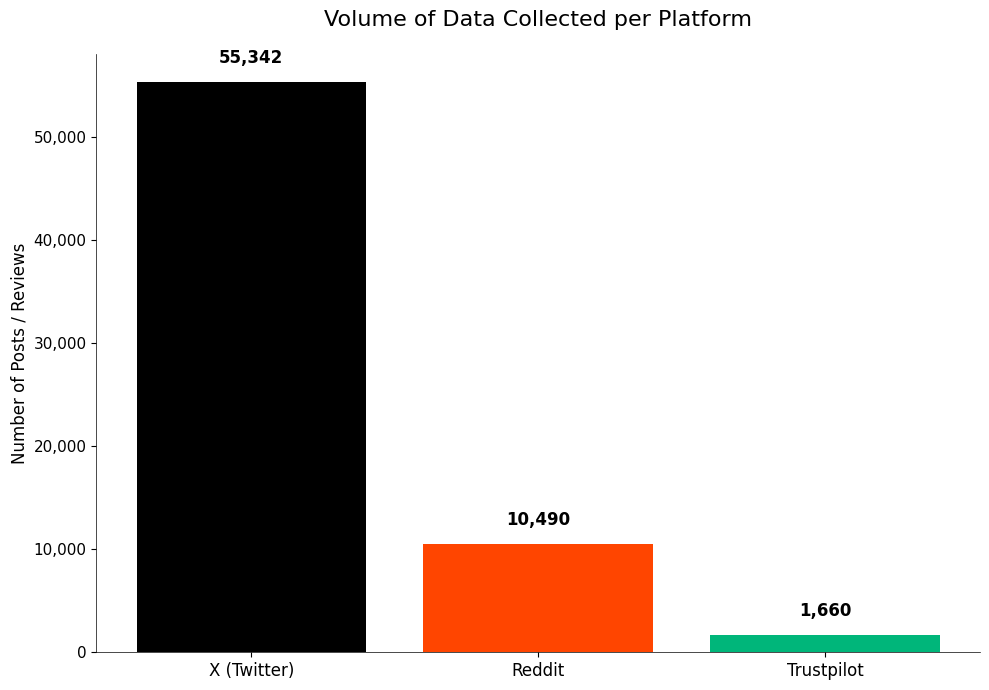

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

combined_df['source'] = combined_df['source'].replace({'Twitter': 'X (Twitter)'})
data_counts = combined_df["source"].value_counts()
df = data_counts.reset_index()
df.columns = ['Platform', 'Count']
color_map = {
    'X (Twitter)': '#000000',
    'Reddit': '#FF4500',
    'Trustpilot': '#00B67A'
}
bar_colors = [color_map[platform] for platform in df['Platform']]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(df['Platform'], df['Count'], color=bar_colors)


for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.0,
        yval + 1500,
        f'{int(yval):,}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

ax.set_title('Volume of Data Collected per Platform', fontsize=16, pad=20, fontweight='normal')
ax.set_ylabel('Number of Posts / Reviews', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

ax.get_yaxis().set_major_formatter(
    mticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.tight_layout()
plt.savefig('data_volume_chart.png', dpi=300)
plt.show()

In [ ]:
import re
import spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

custom_stopwords_sen = set(spacy.lang.en.stop_words.STOP_WORDS)
custom_stopwords_sen.update([

    # Generic booking & platform noise
    "airbnb", "air", "bnb", "host", "booking", "stay", "apartment", "room", "night", "hotel", "place", "customer", "usa"
    "guest", "people", "use", "book", "booking", "stay", "service", "day", "time", "property", "company", "subreddit"
    "review", "issue", "platform", "account", "support", "email", "owner", "rent", "house", "home", "place",
    "need", "find", "let", "get", "check", "look", "try", "know", "see", "start", "allow", "provide", "include",
    "listing", "system", "account", "message", "option", "request", "detail", "description", "unit", "email",

    # Vague & non-informative verbs & adjectives
    "work", "send", "receive", "run", "way", "thing", "long", "right", "good", "bad", "new", "actually",
    "probably", "maybe", "sure", "live", "year", "month", "day", "amp",

    # Twitter handle patterns
    "dojacat", "lukeburgi", "colmoedavis", "airbnbhelp", "grandeurnext",

    # Generic sentiment-less action words
    "ask", "tell", "leave", "try", "get", "come", "go", "make", "know", "thing", "want", "think"

    # Already captured in lemmatised forms
    "happen", "reason", "experience", "situation", "change", "action", "perform", "compose", "don"
    ])

def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in custom_stopwords_sen
        and len(token.lemma_) > 2
        and token.is_alpha
    ]
    return " ".join(tokens)

combined_df["clean_text"] = combined_df["text"].apply(clean_and_lemmatize)
combined_df[["text", "clean_text", "source"]].head()

text  \
0  @_hoodxhippie @Airbnb Marriott has stuff on th...   
1  @MrNIOinc @Airbnb It looks you are having a ro...   
2  @the_q_478 @Airbnb I will be looking into that...   
3  @Airbnb @bchesky got falsely blamed for damagi...   
4  So what is wrong about the review via guest an...   

                                          clean_text   source  
0  hoodxhippie marriott stuff vacation club townh...  Twitter  
1        mrnioinc rough peru colombia paradise buddy  Twitter  
2                                       forward life  Twitter  
3  bchesky falsely blame damage pay damage photo ...  Twitter  
4  wrong review guest exploit simply ruin operati...  Twitter

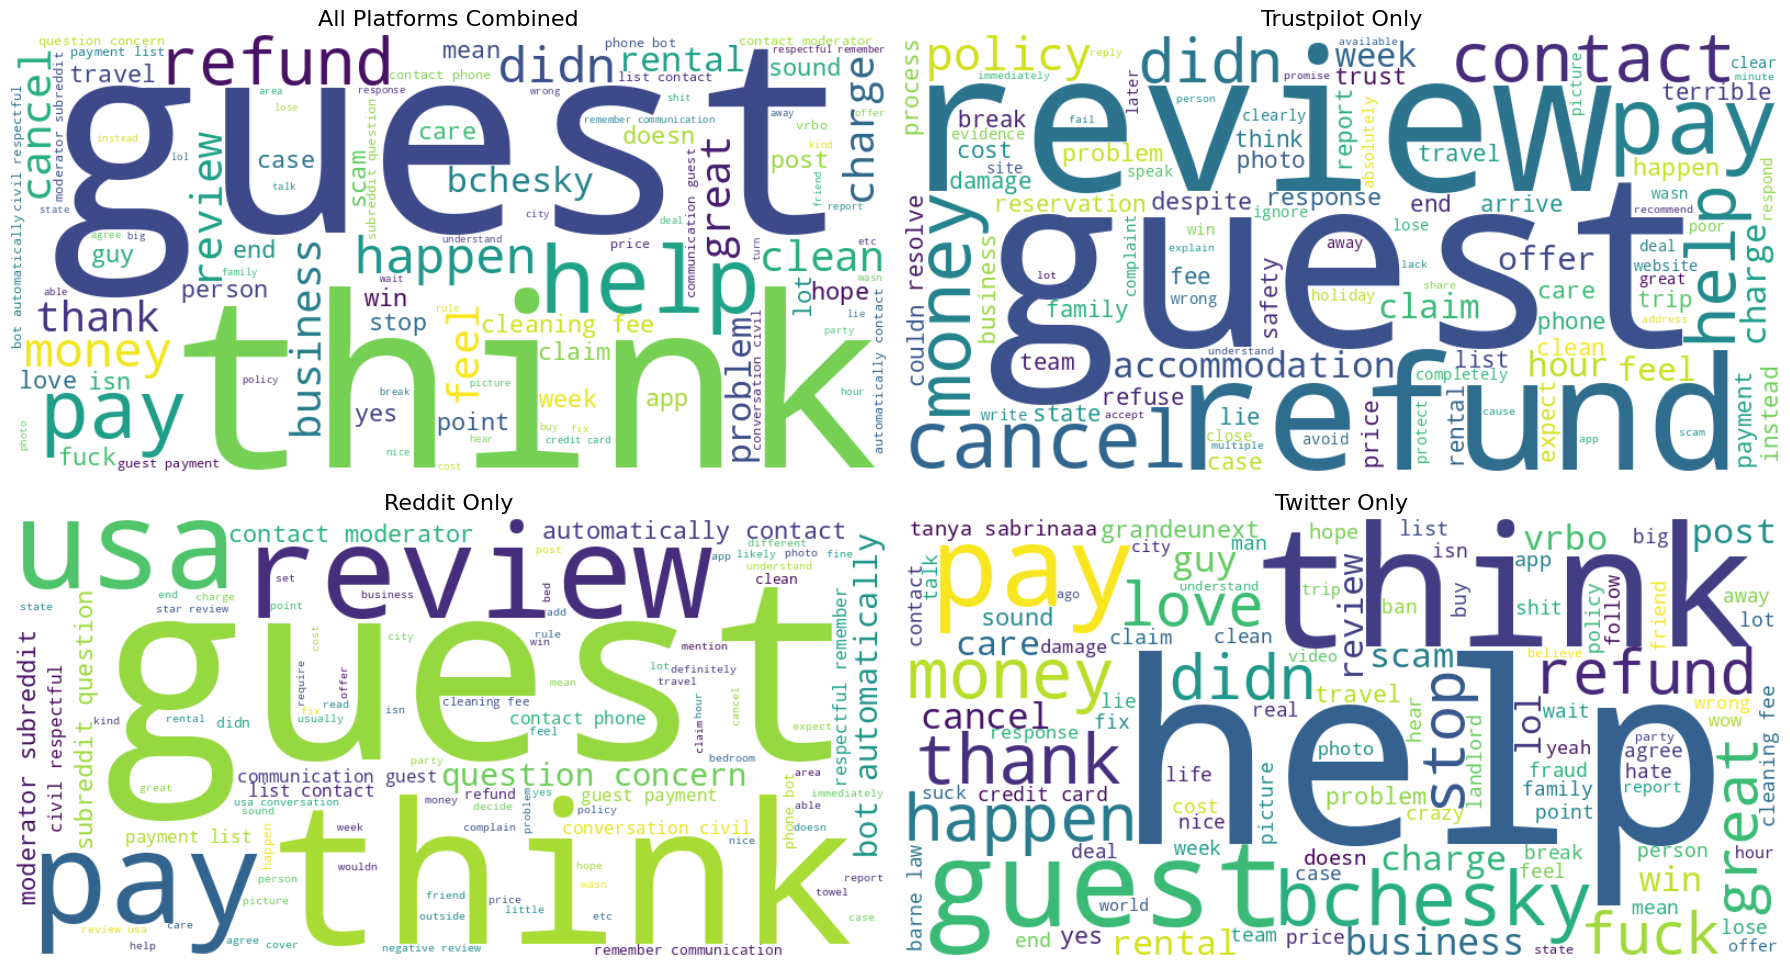

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_text_by_source(df, source=None):
    if source:
        return " ".join(df[df["source"] == source]["clean_text"].dropna().values)
    else:
        return " ".join(df["clean_text"].dropna().values)

text_combined = get_text_by_source(combined_df)
text_trustpilot = get_text_by_source(combined_df, "Trustpilot")
text_reddit = get_text_by_source(combined_df, "Reddit")
text_twitter = get_text_by_source(combined_df, "Twitter")

fig, axs = plt.subplots(2, 2, figsize=(18, 10))

def plot_wordcloud(text, ax, title):
    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontsize=16)
    ax.axis("off")

plot_wordcloud(text_combined, axs[0, 0], "All Platforms Combined")
plot_wordcloud(text_trustpilot, axs[0, 1], "Trustpilot Only")
plot_wordcloud(text_reddit, axs[1, 0], "Reddit Only")
plot_wordcloud(text_twitter, axs[1, 1], "Twitter Only")

plt.tight_layout()
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def predict_sentiment(text):
    try:
        result = sentiment_pipe(text[:512])[0]
        return result["label"].lower(), float(result["score"])
    except Exception as e:
        return "error", 0.0

sentiment_results = combined_df["clean_text"].apply(predict_sentiment)
combined_df[["sentiment_label", "sentiment_score"]] = pd.DataFrame(sentiment_results.tolist(), index=combined_df.index)

print("✅ Sentiment distribution:\n", combined_df["sentiment_label"].value_counts())
combined_df[["clean_text", "sentiment_label", "sentiment_score", "source"]].sample(10)

Device set to use cuda:0


✅ Sentiment distribution:
 sentiment_label
label_1    39027
label_0    22942
label_2     5523
Name: count, dtype: int64


clean_text sentiment_label  \
14360                  onikaeternal yslonika grandeunext         label_1   
49343  neiljhk redgoldsecurity instagram handle like ...         label_2   
5252   jamesgaffney dubcitycouncil dept ecc lordmayor...         label_1   
55452  recent question usa eek question like bring gu...         label_1   
632    skift employ software root felon alias address...         label_1   
13960                          grandeunext fuck timeline         label_0   
37945  creator joe pedophile party realdonaldtrump el...         label_0   
36170  mayorsrb foxbaltimore mikenziefrost read trust...         label_0   
42765  occur homework beer listen different point vie...         label_0   
61496               refuse refund small cleaning usa bug         label_1   

       sentiment_score   source  
14360         0.873742  Twitter  
49343         0.578627  Twitter  
5252          0.838742  Twitter  
55452         0.742418   Reddit  
632           0.806521  Twitter  
13960         0.939672  Twitter  
37945         0.861737  Twitter  
36170         0.815108  Twitter  
42765         0.612928  Twitter  
61496         0.490161   Reddit

In [ ]:
combined_df.head()

date                                               text  \
0 2024-07-01 00:26:42  @_hoodxhippie @Airbnb Marriott has stuff on th...   
1 2024-07-01 00:51:46  @MrNIOinc @Airbnb It looks you are having a ro...   
2 2024-07-01 01:11:53  @the_q_478 @Airbnb I will be looking into that...   
3 2024-07-01 01:22:29  @Airbnb @bchesky got falsely blamed for damagi...   
4 2024-07-01 01:27:06  So what is wrong about the review via guest an...   

    source                                         clean_text sentiment_label  \
0  Twitter  hoodxhippie marriott stuff vacation club townh...         label_1   
1  Twitter        mrnioinc rough peru colombia paradise buddy         label_1   
2  Twitter                               forward air bnb life         label_1   
3  Twitter  bchesky falsely blame damage pay damage photo ...         label_0   
4  Twitter  wrong exploit simply ruin operation easily roh...         label_0   

   sentiment_score  
0         0.869354  
1         0.793845  
2         0.763022  
3         0.802599  
4         0.872964

/tmp/ipython-input-4065169014.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-4065169014.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{int(combined_counts[i])} ({v:.1f}%)",


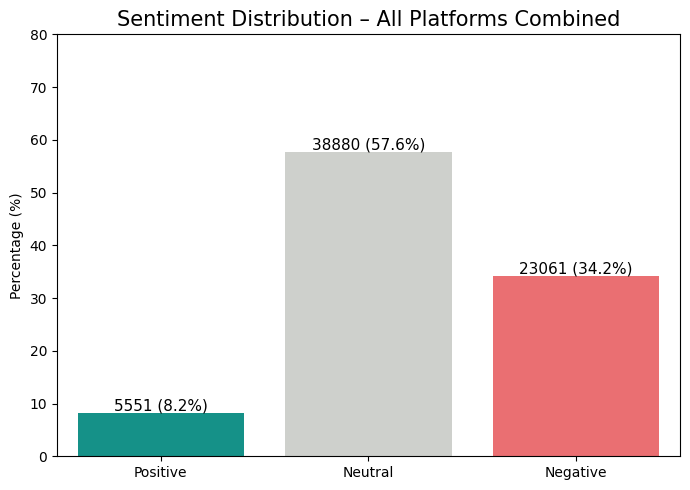

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_map = { "label_0": "Negative", "label_1": "Neutral", "label_2": "Positive",}
order = ["Positive", "Neutral", "Negative"]
colors = {"Positive": "#00a699", "Neutral":  "#ced1cb",  "Negative": "#ff5a5f"}

combined_df["source"] = combined_df["source"].replace({"Twitter": "X (Twitter)"})
plot_df = combined_df.copy()
plot_df["sentiment_label"] = (plot_df["sentiment_label"].astype(str).str.strip().map(label_map))
plot_df["source"] = plot_df["source"].astype(str).str.strip().str.title()
plot_df = plot_df[plot_df["sentiment_label"].isin(order)]

# Combined Chart
combined_counts = (
    plot_df["sentiment_label"]
    .value_counts()
    .reindex(order)
    .fillna(0)
)
total_all = combined_counts.sum()
combined_percent = (combined_counts / total_all) * 100

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=combined_percent.index,
    y=combined_percent.values,
    order=order,
    palette=[colors[k] for k in order]
)
for i, v in enumerate(combined_percent.values):
    ax.text(i, v + 0.5, f"{int(combined_counts[i])} ({v:.1f}%)",
            ha="center", fontsize=11)
ax.set_title("Sentiment Distribution – All Platforms Combined", fontsize=15)
ax.set_xlabel("")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 80)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4169636836.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4169636836.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{int(counts[i])} ({v:.1f}%)",
/tmp/ipython-input-4169636836.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4169636836.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

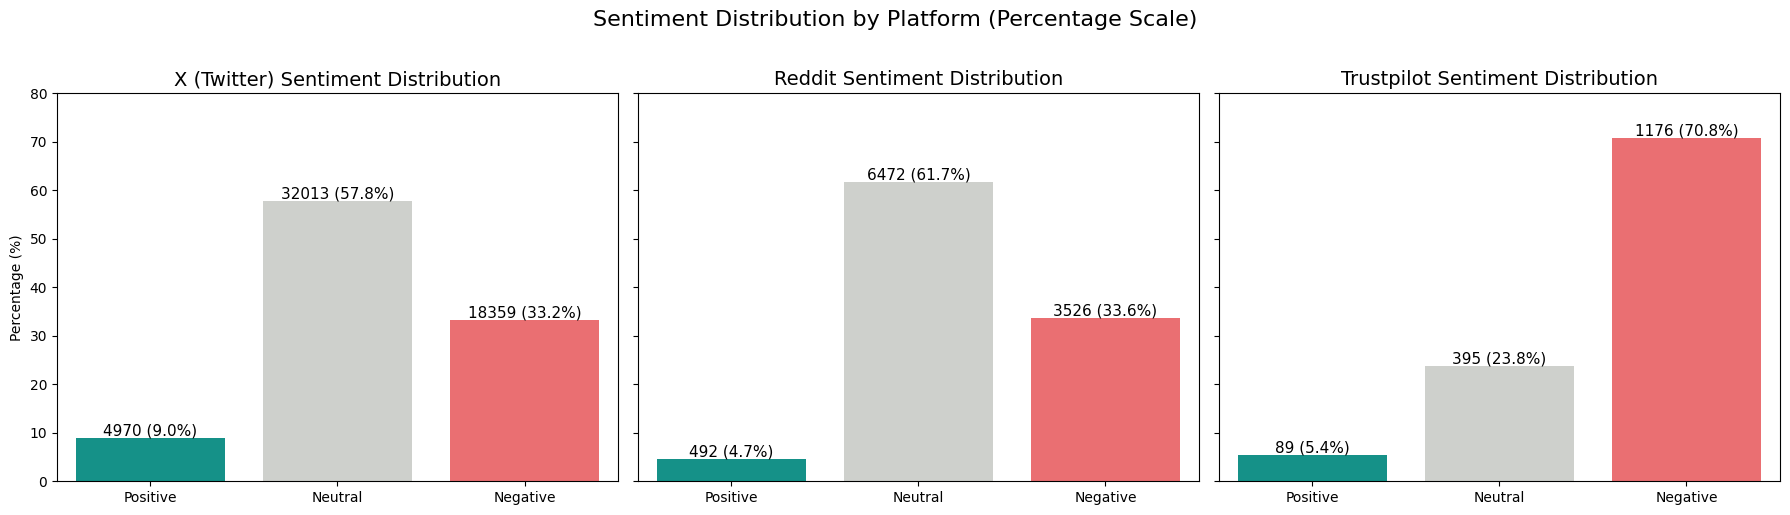

In [ ]:
# Per-Platform Charts
platforms = plot_df["source"].dropna().unique()
n = len(platforms)
fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

if n == 1:
    axes = [axes]

for ax, platform in zip(axes, platforms):
    counts = (
        plot_df.loc[plot_df["source"] == platform, "sentiment_label"]
        .value_counts()
        .reindex(order)
        .fillna(0)
    )
    total = counts.sum()
    percents = (counts / total) * 100 if total > 0 else counts

    sns.barplot(
        x=percents.index,
        y=percents.values,
        order=order,
        palette=[colors[k] for k in order],
        ax=ax
    )

    for i, v in enumerate(percents.values):
        ax.text(i, v + 0.5, f"{int(counts[i])} ({v:.1f}%)",
                ha="center", fontsize=11)

    ax.set_title(f"{platform} Sentiment Distribution", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 80)

fig.suptitle("Sentiment Distribution by Platform (Percentage Scale)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
combined_df.to_csv("combined_sentiment_data.csv", index=False)

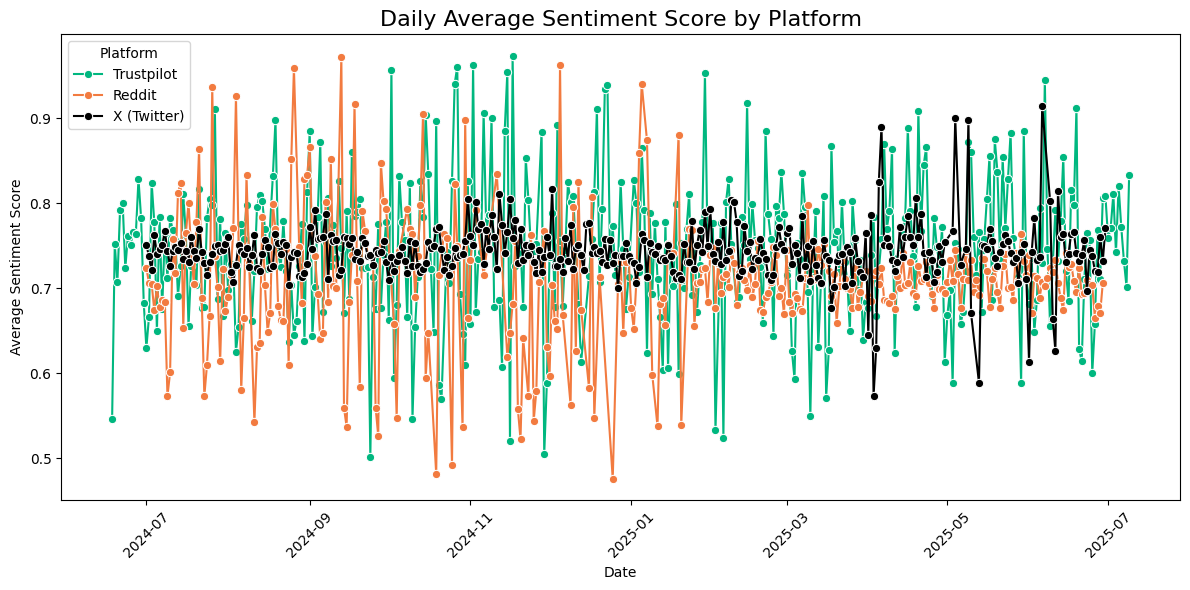

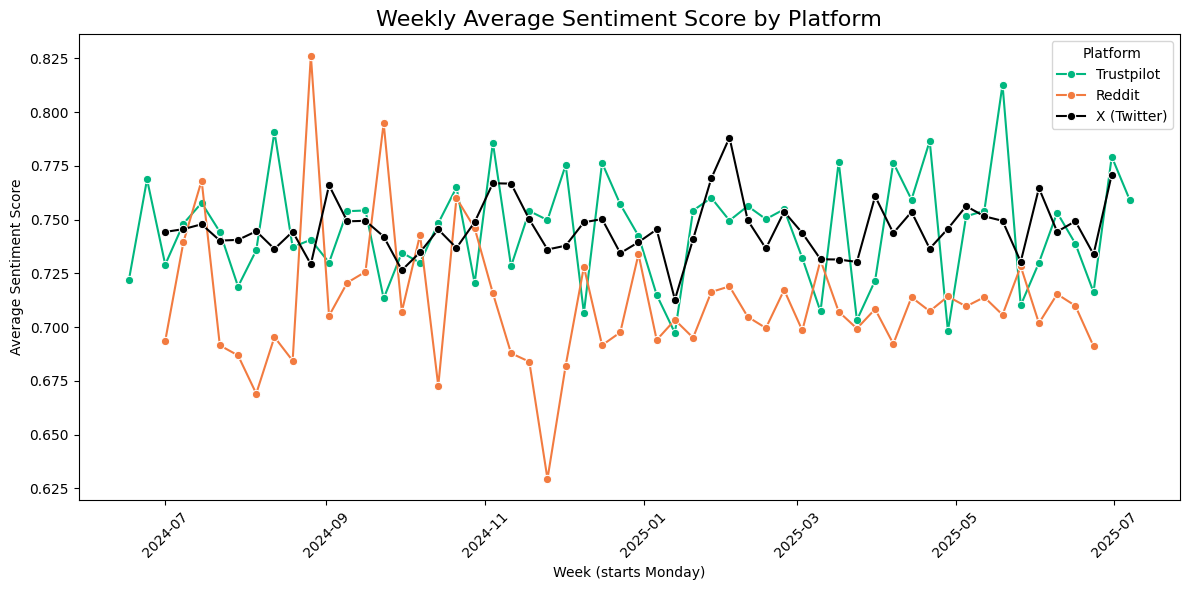

In [ ]:
df_plot_2 = combined_df.copy()
df_plot_2["date"] = pd.to_datetime(df_plot_2["date"], errors="coerce")
try:
    df_plot_2["date"] = df_plot_2["date"].dt.tz_localize(None)
except Exception:
    pass

df_plot_2["sentiment_score"] = pd.to_numeric(df_plot_2["sentiment_score"], errors="coerce")
df_plot_2 = df_plot_2.dropna(subset=["date", "sentiment_score"])
platform_colors = {"X (Twitter)": "#000000", "Reddit": "#f27b40", "Trustpilot": "#00b77f"}

# DAILY AVERAGE CONFIDENCE SCORE
daily_avg_scores = (
    df_plot_2
      .set_index("date")
      .groupby("source")
      .resample("D")["sentiment_score"]
      .mean()
      .reset_index()
      .sort_values("date")
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_avg_scores,
    x="date", y="sentiment_score",
    hue="source", palette=platform_colors, marker="o"
)
plt.title("Daily Average Sentiment Score by Platform", fontsize=16)
plt.xlabel("Date"); plt.ylabel("Average Sentiment Score")
plt.legend(title="Platform"); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

# WEEKLY AVERAGE CONFIDENCE SCORE
weekly_scores = (
    df_plot_2
      .set_index("date")
      .groupby("source")
      .resample("W-MON", label="left", closed="left")["sentiment_score"]
      .mean()
      .reset_index()
      .rename(columns={"date": "week"})
      .sort_values("week")
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekly_scores,
    x="week", y="sentiment_score",
    hue="source", palette=platform_colors, marker="o"
)
plt.title("Weekly Average Sentiment Score by Platform", fontsize=16)
plt.xlabel("Week (starts Monday)"); plt.ylabel("Average Sentiment Score")
plt.legend(title="Platform"); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

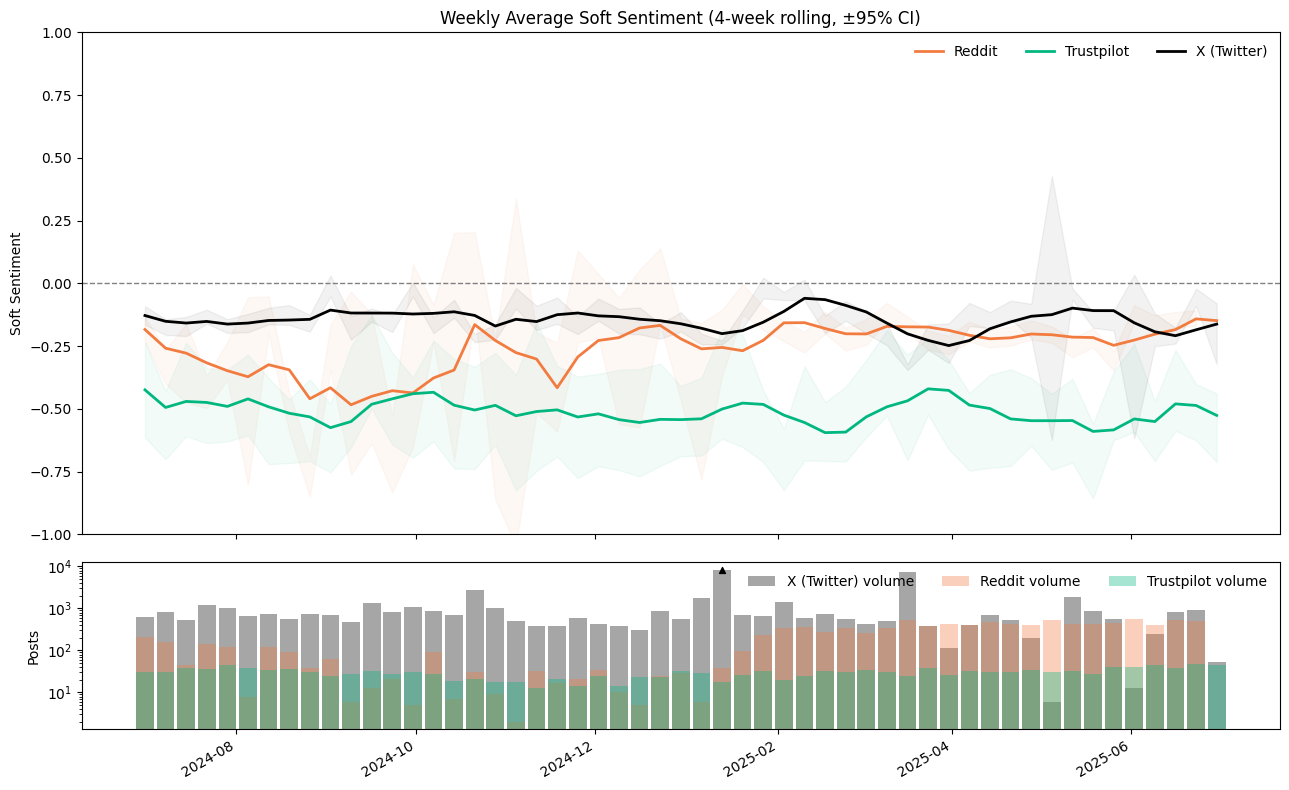

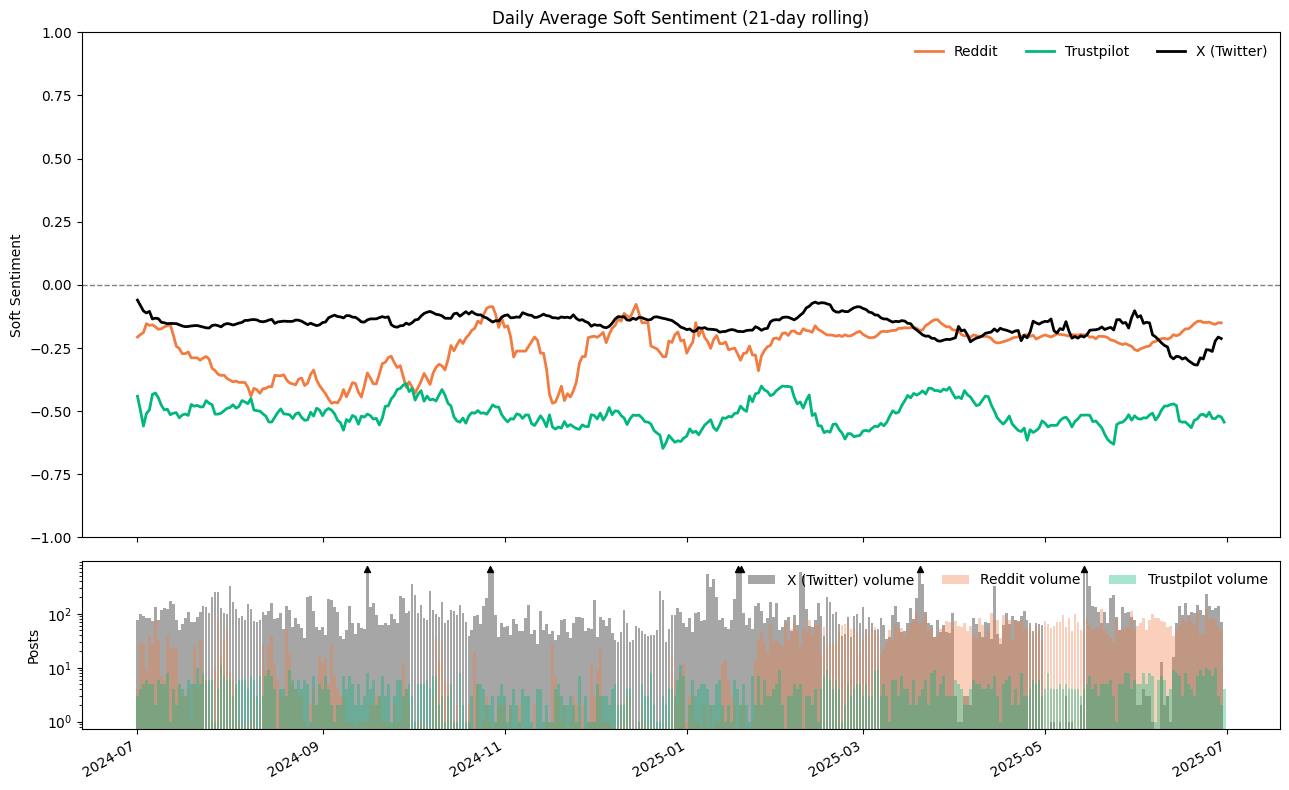

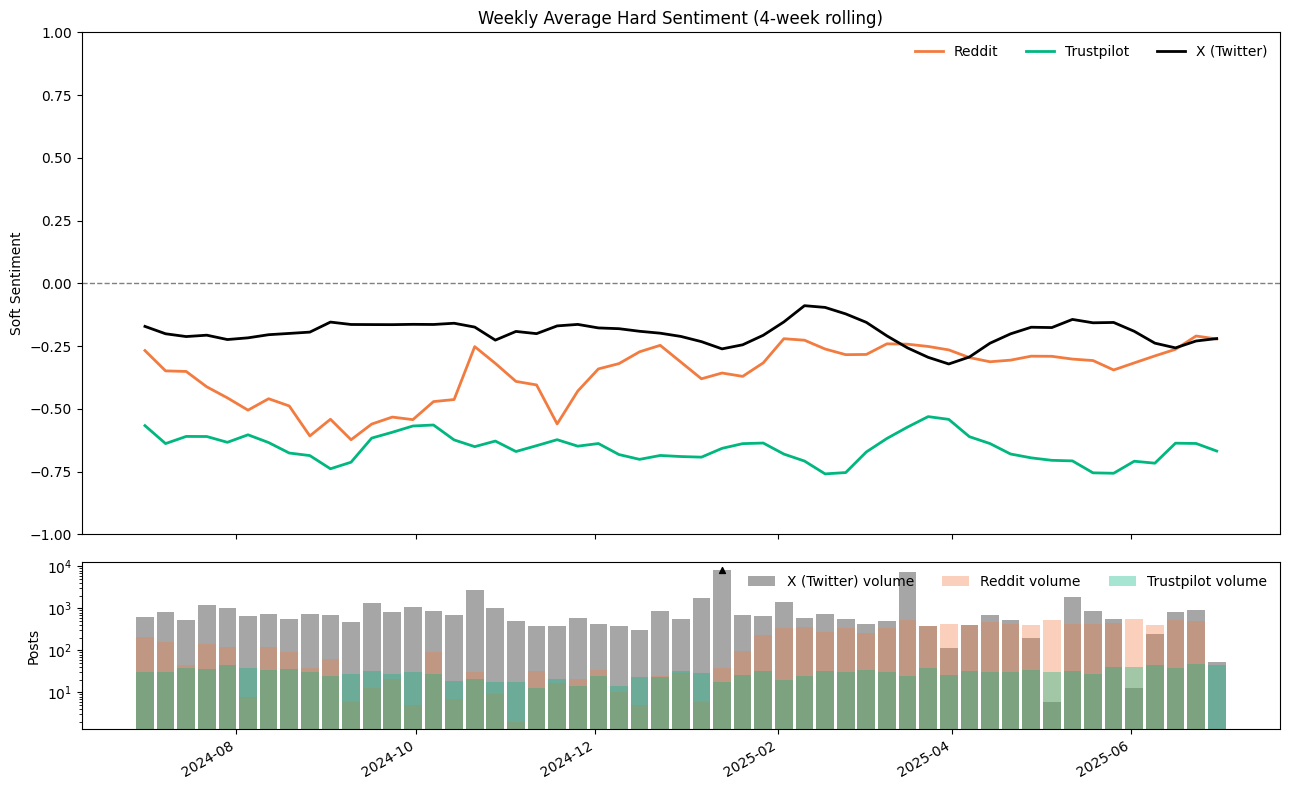


Weekly volume outliers (clipped):
week_start      source  n_posts  n_posts_clipped
2025-01-13 X (Twitter)  11593.0          8381.65

Daily volume outliers (clipped):
      date      source  n_posts  n_posts_clipped
2024-09-16 X (Twitter)      764            685.4
2024-10-27 X (Twitter)     2146            685.4
2025-01-18 X (Twitter)    10261            685.4
2025-01-19 X (Twitter)      871            685.4
2025-03-20 X (Twitter)     6591            685.4
2025-05-14 X (Twitter)      713            685.4


In [ ]:
import numpy as np
from matplotlib.dates import MonthLocator, DateFormatter

START_DATE = "2024-07-01"
END_DATE   = "2025-06-30"

ROLL_DAYS   = 21
ROLL_WEEKS  = 4

MIN_POSTS_DAILY = 0
MIN_POSTS_WEEKLY = 0

USE_LOG_VOLUME  = True
CLIP_VOLUME_PCT = 99.5
CI_ALPHA_WEEKLY = 0.05

COLORS = {"X (Twitter)": "#000000", "Reddit": "#f27b40", "Trustpilot": "#00b77f"}

df = combined_df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
try:
    df["date"] = df["date"].dt.tz_localize(None)
except Exception:
    pass
df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)]

sign_map = {"label_0": -1, "Negative": -1,
            "label_1": 0,  "Neutral": 0,
            "label_2": 1,  "Positive": 1}
df["sign"] = df["sentiment_label"].map(sign_map)
df["sentiment_score"] = pd.to_numeric(df["sentiment_score"], errors="coerce")
df = df.dropna(subset=["date", "sign", "sentiment_score"])

df["soft_sent"] = df["sign"] * df["sentiment_score"]
df["hard_sent"] = df["sign"]

# Daily aggregation
daily = (
    df.set_index("date").groupby("source").resample("D")
      .agg(soft_mean=("soft_sent","mean"),
           soft_std=("soft_sent","std"),
           n_posts=("sign","count"))
      .reset_index()
)
daily["soft_roll"] = daily.groupby("source")["soft_mean"].transform(
    lambda s: s.rolling(ROLL_DAYS, min_periods=1).mean()
)

# Weekly aggregation
END_DATE_TS = pd.to_datetime(END_DATE)
END_DATE_WEEKLY = END_DATE_TS + pd.Timedelta(days=(6 - END_DATE_TS.weekday()))  # move to Sunday

df_week = combined_df.copy()
df_week["date"] = pd.to_datetime(df_week["date"], errors="coerce")
try:
    df_week["date"] = df_week["date"].dt.tz_localize(None)
except Exception:
    pass
df_week = df_week[(df_week["date"] >= START_DATE) & (df_week["date"] <= END_DATE_WEEKLY)]

df_week["sign"] = df_week["sentiment_label"].map(sign_map)
df_week["sentiment_score"] = pd.to_numeric(df_week["sentiment_score"], errors="coerce")
df_week = df_week.dropna(subset=["date", "sign", "sentiment_score"])
df_week["soft_sent"] = df_week["sign"] * df_week["sentiment_score"]
df_week["hard_sent"] = df_week["sign"]

weekly = (
    df_week.set_index("date").groupby("source")
      .resample("W-MON", label="left", closed="left")
      .agg(soft_mean=("soft_sent","mean"),
           soft_std=("soft_sent","std"),
           n_posts=("sign","count"))
      .reset_index().rename(columns={"date":"week_start"})
)

def pad_weeks_per_source(wdf: pd.DataFrame) -> pd.DataFrame:
    all_mondays = pd.date_range(wdf["week_start"].min(), wdf["week_start"].max(), freq="W-MON")
    sources = wdf["source"].unique()
    full_ix = pd.MultiIndex.from_product([sources, all_mondays], names=["source","week_start"])
    out = (wdf.set_index(["source","week_start"]).reindex(full_ix).reset_index())
    if "n_posts" in out.columns:
        out["n_posts"] = out["n_posts"].fillna(0)
    return out

weekly = pad_weeks_per_source(weekly)

denom = weekly["n_posts"].replace(0, np.nan)
weekly["se"]      = weekly["soft_std"] / np.sqrt(denom)
weekly["ci_low"]  = weekly["soft_mean"] - 1.96 * weekly["se"]
weekly["ci_high"] = weekly["soft_mean"] + 1.96 * weekly["se"]

weekly["soft_roll"] = weekly.groupby("source")["soft_mean"].transform(
    lambda s: s.rolling(ROLL_WEEKS, min_periods=1).mean()
)

def clip_volume(df_in: pd.DataFrame, pct: float | None) -> pd.DataFrame:
    out = df_in.copy()
    if pct is None:
        out["n_posts_clipped"] = out["n_posts"]
        out["is_clipped"] = False
        return out
    lim = out["n_posts"].quantile(pct / 100.0)
    out["n_posts_clipped"] = np.minimum(out["n_posts"], lim)
    out["is_clipped"] = out["n_posts"] > lim
    return out

def outlier_table(df_in: pd.DataFrame) -> pd.DataFrame:
    idx_col = "date" if "date" in df_in.columns else "week_start"
    cols = [idx_col, "source", "n_posts", "n_posts_clipped"]
    return df_in.loc[df_in.get("is_clipped", False), cols].sort_values([idx_col, "source"])

daily  = clip_volume(daily, CLIP_VOLUME_PCT)
weekly = clip_volume(weekly, CLIP_VOLUME_PCT)
-
def plot_sentiment_with_volume(df_in, xcol, ycol, title, min_posts,
                               show_ci=False, volume_log=USE_LOG_VOLUME,
                               bar_width=None, volume_order=("X (Twitter)","Reddit","Trustpilot")):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True,
                                   gridspec_kw={"height_ratios":[3,1]})

    if bar_width is None:
        bar_width = 6 if xcol in ("week_start","week") else 0.9

    for src, g in df_in.groupby("source"):
        c = COLORS.get(src, "#333")
        ax1.plot(g[xcol], g[ycol], lw=2, label=src, color=c)
        if show_ci and {"ci_low","ci_high"}.issubset(g.columns):
            ax1.fill_between(g[xcol], g["ci_low"], g["ci_high"], alpha=CI_ALPHA_WEEKLY, color=c)

    n_col = "n_posts_clipped" if "n_posts_clipped" in df_in.columns else "n_posts"
    clipped_flag = "is_clipped" if "is_clipped" in df_in.columns else None
    present = list(df_in["source"].unique())
    ordered_sources = [s for s in volume_order if s in present] + [s for s in present if s not in volume_order]

    for src in ordered_sources:
        gbar = df_in[(df_in["source"] == src) & (df_in["n_posts"] >= min_posts)]
        c = COLORS.get(src, "#333")
        ax2.bar(gbar[xcol], gbar[n_col], width=bar_width, align="center",
                color=c, alpha=0.35, label=f"{src} volume")
        if clipped_flag and gbar[clipped_flag].any():
            clipped = gbar[gbar[clipped_flag]]
            ax2.scatter(clipped[xcol], clipped[n_col], s=18, marker="^", color=c, zorder=3)

    ax1.axhline(0, ls="--", lw=1, color="gray")
    ax1.set_ylim(-1, 1)
    ax1.set_ylabel("Soft Sentiment")
    ax1.set_title(title)
    ax1.legend(ncol=3, frameon=False)

    ax2.set_ylabel("Posts")
    if volume_log:
        ax2.set_yscale("log")
    ax2.legend(ncol=3, frameon=False)
    ax2.xaxis.set_major_locator(MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

    plt.tight_layout()
    plt.show()

plot_sentiment_with_volume(
    weekly, "week_start", "soft_roll",
    title=f"Weekly Average Soft Sentiment ({ROLL_WEEKS}-week rolling, ±95% CI)",
    min_posts=MIN_POSTS_WEEKLY, show_ci=True, volume_log=USE_LOG_VOLUME,
    bar_width=6, volume_order=("X (Twitter)","Reddit","Trustpilot")
)

plot_sentiment_with_volume(
    daily, "date", "soft_roll",
    title=f"Daily Average Soft Sentiment ({ROLL_DAYS}-day rolling)",
    min_posts=MIN_POSTS_DAILY, show_ci=False, volume_log=USE_LOG_VOLUME,
    volume_order=("X (Twitter)","Reddit","Trustpilot")
)

# Weekly Hard sentiment
weekly_hard = (
    df_week.set_index("date").groupby("source")
      .resample("W-MON", label="left", closed="left")
      .agg(hard_mean=("hard_sent","mean"), n_posts=("sign","count"))
      .reset_index().rename(columns={"date":"week_start"})
)
weekly_hard = pad_weeks_per_source(weekly_hard)

# Recompute rolling AFTER padding
weekly_hard["hard_roll"] = weekly_hard.groupby("source")["hard_mean"].transform(
    lambda s: s.rolling(ROLL_WEEKS, min_periods=1).mean()
)

weekly_hard = clip_volume(weekly_hard, CLIP_VOLUME_PCT)

plot_sentiment_with_volume(
    weekly_hard, "week_start", "hard_roll",
    title=f"Weekly Average Hard Sentiment ({ROLL_WEEKS}-week rolling)",
    min_posts=MIN_POSTS_WEEKLY, show_ci=False, volume_log=USE_LOG_VOLUME,
    bar_width=6, volume_order=("X (Twitter)","Reddit","Trustpilot")
)

# Outlier tables
def outlier_table(df_in: pd.DataFrame) -> pd.DataFrame:
    idx_col = "date" if "date" in df_in.columns else "week_start"
    cols = [idx_col, "source", "n_posts", "n_posts_clipped"]
    return df_in.loc[df_in.get("is_clipped", False), cols].sort_values([idx_col, "source"])

weekly_outliers = outlier_table(weekly)
daily_outliers  = outlier_table(daily)
print("\nWeekly volume outliers (clipped):")
print(weekly_outliers.head(20).to_string(index=False))
print("\nDaily volume outliers (clipped):")
print(daily_outliers.head(20).to_string(index=False))

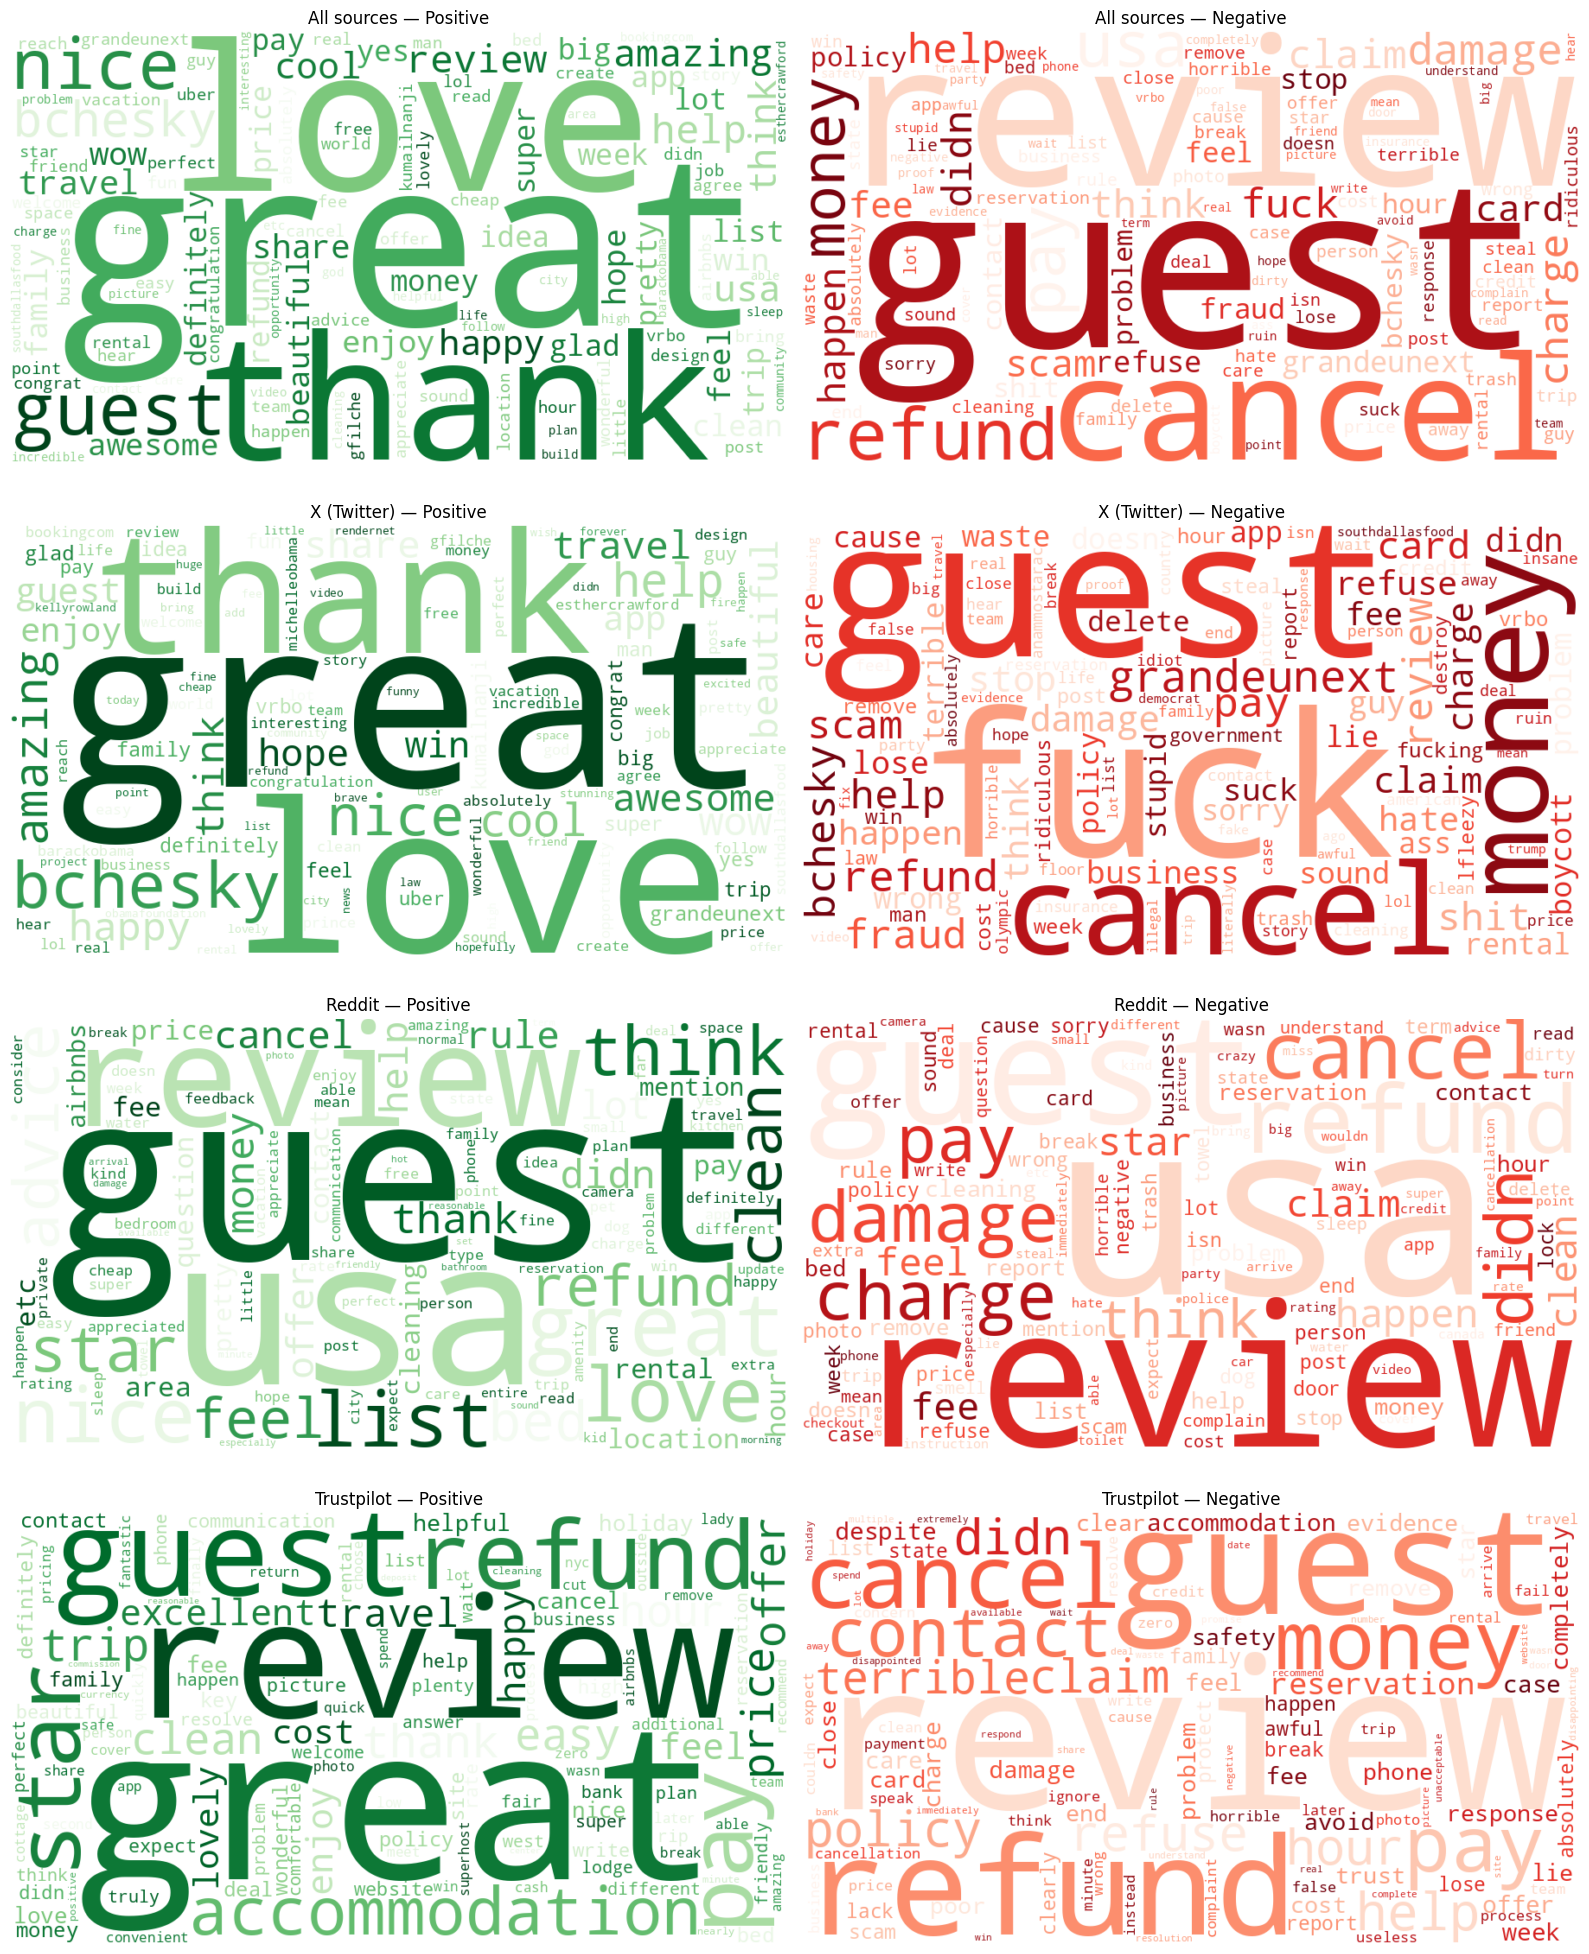

In [ ]:
df_wc = combined_df.copy()
df_wc["source"] = df_wc["source"].replace({"Twitter": "X (Twitter)"})

def plot_sentiment_wordclouds(
    df_wc,
    text_col="clean_text",
    label_col="sentiment_label",
    source_col="source",
    pos_values=("label_2", "Positive"),
    neg_values=("label_0", "Negative"),
    width=900, height=500, max_words=120,
    pos_cmap="Greens", neg_cmap="Reds",
):

    d = df_wc[[text_col, label_col, source_col]].copy()

    rows = [
        ("All sources", d),
        ("X (Twitter)", d[d[source_col] == "X (Twitter)"]),
        ("Reddit",      d[d[source_col] == "Reddit"]),
        ("Trustpilot",  d[d[source_col] == "Trustpilot"]),
    ]

    def texts_for(sub, wanted):
        return sub.loc[sub[label_col].isin(wanted), text_col].dropna().astype(str).tolist()

    def draw_wc(ax, texts, title, cmap):
        if not texts:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off"); ax.set_title(title); return
        wc = WordCloud(
            width=width, height=height,
            background_color="white",
            colormap=cmap,         # <-- color map here
            max_words=max_words,
            collocations=False
        ).generate(" ".join(texts))
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(title, fontsize=12)

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
    for r, (name, sub) in enumerate(rows):
        pos_texts = texts_for(sub, pos_values)
        neg_texts = texts_for(sub, neg_values)
        draw_wc(axes[r, 0], pos_texts, f"{name} — Positive", pos_cmap)
        draw_wc(axes[r, 1], neg_texts, f"{name} — Negative", neg_cmap)

    plt.tight_layout()
    plt.show()

plot_sentiment_wordclouds(df_wc, text_col="clean_text")

In [ ]:
RAW_URL = "https://raw.githubusercontent.com/WinNatch/Dissertation/main/combined_sentiment_data.csv"

START_DATE = "2024-07-01"
END_DATE   = "2025-06-30"
ROW_ORDER  = ["X (Twitter)", "Reddit", "Trustpilot"]
DECIMALS   = 3

combined_df = pd.read_csv(RAW_URL, low_memory=False)

def normalize_platform_column(series: pd.Series) -> pd.Series:
    s  = series.astype(str).str.strip()
    sl = s.str.lower()
    is_x  = sl.str.contains(r"\btwitter\b") | (sl == "x") | (sl == "x.com") | sl.str.contains(r"\bx \(twitter\)\b")
    is_rd = sl.str.contains("reddit", regex=False)
    is_tp = sl.str.contains("trust ?pilot", regex=True)
    out = s.copy()
    out = np.where(is_x,  "X (Twitter)", out)
    out = np.where(is_rd, "Reddit", out)
    out = np.where(is_tp, "Trustpilot", out)
    return pd.Series(out, index=series.index)

combined_df["source"] = normalize_platform_column(combined_df["source"])

sign_map = {
    "label_0": -1, "Negative": -1,
    "label_1":  0, "Neutral":  0,
    "label_2":  1, "Positive": 1
}
sign_series = combined_df["sentiment_label"].map(sign_map)

sign_num = pd.to_numeric(combined_df["sentiment_label"], errors="coerce")
sign_num = sign_num.where(~sign_num.isin([0, 1, 2]), sign_num.map({0: -1, 1: 0, 2: 1}))
combined_df["sign"] = sign_series.fillna(sign_num).astype(float)

combined_df["sentiment_score"] = pd.to_numeric(combined_df["sentiment_score"], errors="coerce")
combined_df["soft_sent"] = combined_df["sign"] * combined_df["sentiment_score"]
combined_df["hard_sent"] = combined_df["sign"]

combined_df["date"] = pd.to_datetime(combined_df["date"], errors="coerce")
try:
    combined_df["date"] = combined_df["date"].dt.tz_localize(None)
except Exception:
    pass

if START_DATE is None:
    START_DATE = combined_df["date"].min().normalize()
else:
    START_DATE = pd.to_datetime(START_DATE)

if END_DATE is None:
    END_DATE = combined_df["date"].max().normalize()
else:
    END_DATE = pd.to_datetime(END_DATE)

END_DATE_WEEKLY = END_DATE + pd.Timedelta(days=(6 - END_DATE.weekday()))

df_week = combined_df[(combined_df["date"] >= START_DATE) & (combined_df["date"] <= END_DATE_WEEKLY)].copy()
df_week = df_week.dropna(subset=["date", "sign", "sentiment_score"])

weekly = (
    df_week.set_index("date").groupby("source")
    .resample("W-MON", label="left", closed="left")
    .agg(soft_mean=("soft_sent", "mean"),
         soft_std =("soft_sent", "std"),
         n_posts  =("sign", "count"))
    .reset_index().rename(columns={"date": "week_start"})
)

def pad_weeks_per_source(wdf: pd.DataFrame) -> pd.DataFrame:
    all_mondays = pd.date_range(wdf["week_start"].min(), wdf["week_start"].max(), freq="W-MON")
    sources = wdf["source"].unique()
    full_ix = pd.MultiIndex.from_product([sources, all_mondays], names=["source", "week_start"])
    out = wdf.set_index(["source", "week_start"]).reindex(full_ix).reset_index()
    if "n_posts" in out.columns:
        out["n_posts"] = out["n_posts"].fillna(0)
    return out

weekly = pad_weeks_per_source(weekly)

weeks_count = weekly["week_start"].nunique()

def describe_weekly(s: pd.Series) -> pd.Series:
    return pd.Series({
        "Count (n)": weeks_count,
        "Mean": s.mean(skipna=True),
        "Std. Dev. (σ)": s.std(ddof=1, skipna=True),
        "Min": s.min(skipna=True),
        "25% (Q1)": s.quantile(0.25, interpolation="linear"),
        "50% (Median)": s.quantile(0.50, interpolation="linear"),
        "75% (Q3)": s.quantile(0.75, interpolation="linear"),
        "Max": s.max(skipna=True),
    })

table = (
    weekly.groupby("source")["soft_mean"]
    .apply(describe_weekly)
    .unstack()
    .reindex(ROW_ORDER)
)

for col in table.columns:
    if col != "Count (n)":
        table[col] = table[col].round(DECIMALS)

table.index.name = "Platform"

print("\nTable: Descriptive Statistics of Weekly Sentiment Scores (soft_mean) by Platform\n")
print(table.to_string())
table.to_csv("weekly_sentiment_descriptive_stats_by_platform.csv", index=True)


Table: Descriptive Statistics of Weekly Sentiment Scores (soft_mean) by Platform

             Count (n)   Mean  Std. Dev. (σ)    Min  25% (Q1)  50% (Median)  75% (Q3)    Max
Platform                                                                                    
X (Twitter)       53.0 -0.146          0.065 -0.334    -0.177        -0.149    -0.110 -0.010
Reddit            53.0 -0.259          0.155 -0.770    -0.321        -0.230    -0.162  0.044
Trustpilot        53.0 -0.521          0.088 -0.708    -0.575        -0.517    -0.459 -0.357
